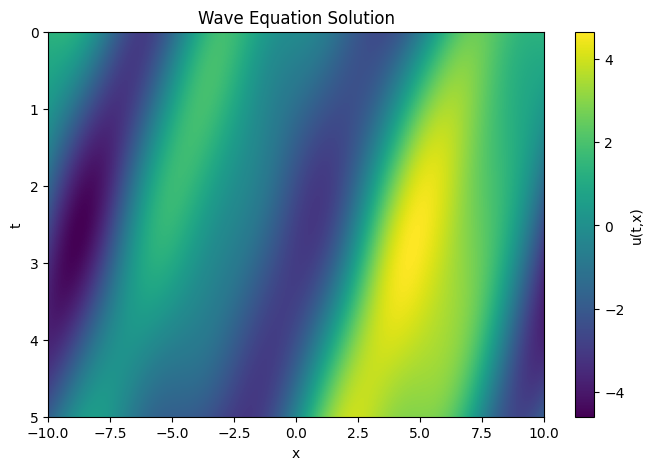

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def sample_initial_conditions(Nx, L):
    """ Generate diverse initial conditions using a mix of sinusoids and localized Gaussians. """
    x = np.linspace(-L, L, Nx, endpoint=False)
    
    # Random Fourier components
    k_max = 10  # Maximum wave number
    amplitudes = np.random.randn(k_max) * np.exp(-np.linspace(0, k_max, k_max)**2 / 10)
    phases = np.random.uniform(0, 2 * np.pi, k_max)
    
    u0 = np.sum([a * np.sin(k * np.pi * x / L + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)
    
    # Add some Gaussian bumps
    num_bumps = np.random.randint(1, 4)
    for _ in range(num_bumps):
        center = np.random.uniform(-L, L)
        width = np.random.uniform(0.1 * L, 0.5 * L)
        height = np.random.uniform(-1, 1)
        u0 += height * np.exp(-((x - center) / width) ** 2)
    
    # Random initial velocity
    u_t0 = np.sum([a * np.cos(k * np.pi * x / L + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)
    
    return x, u0, u_t0

def solve_wave_equation(Nx, Nt, L, T, c):
    """ Solve the wave equation using a spectral method for accuracy. """
    x, u0, u_t0 = sample_initial_conditions(Nx, L)
    
    dx = 2 * L / Nx
    dt = T / Nt
    k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Wave numbers
    
    # Initialize wave field
    u = np.zeros((Nt, Nx))
    u[0, :] = u0

    # First step using explicit Euler
    u_hat = np.fft.fft(u0)
    u_t_hat = np.fft.fft(u_t0)
    
    u1_hat = u_hat + dt * u_t_hat
    u[1, :] = np.fft.ifft(u1_hat).real
    
    # Time stepping with leapfrog
    for n in range(1, Nt - 1):
        u2_hat = 2 * u1_hat - u_hat - (c * dt) ** 2 * (k ** 2) * u1_hat
        u_hat, u1_hat = u1_hat, u2_hat
        u[n + 1, :] = np.fft.ifft(u1_hat).real
    
    return x, np.linspace(0, T, Nt), u

# Parameters
Nx = 256   # Number of spatial points
Nt = 200   # Number of time steps
L = 10.0   # Domain size [-L, L]
T = 5.0    # Final time
c = 1.0    # Wave speed

x, t, u = solve_wave_equation(Nx, Nt, L, T, c)

# Visualize the solution
plt.figure(figsize=(8, 5))
plt.imshow(u, aspect='auto', extent=[-L, L, T, 0], cmap='viridis')
plt.colorbar(label='u(t,x)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Wave Equation Solution')
plt.show()


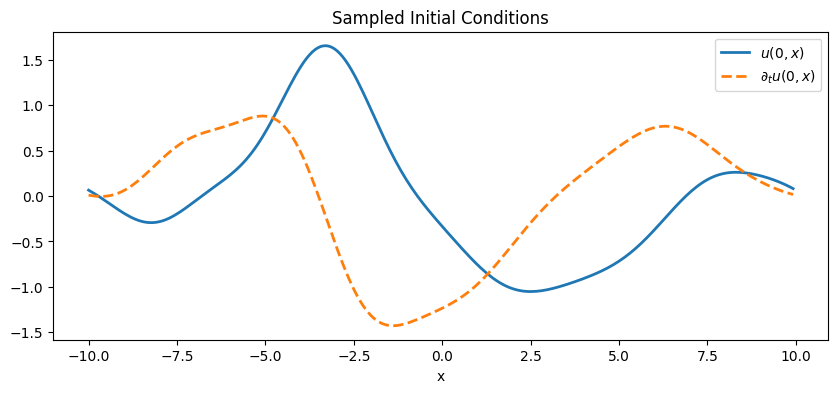

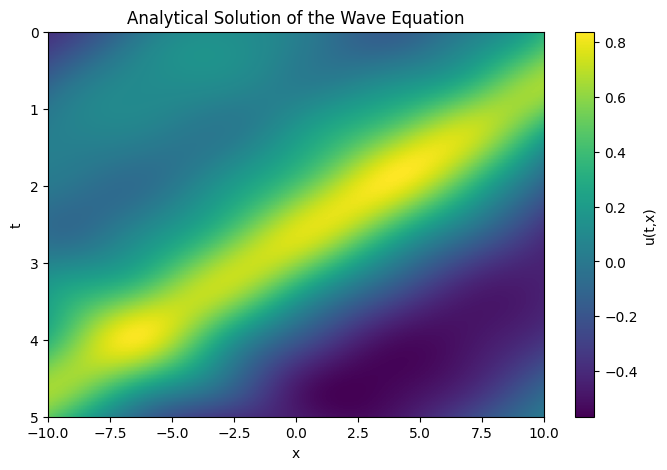

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def sample_initial_conditions(Nx, L, bumps_range = [0,0], add_poly = False):
    """Generate diverse initial conditions using random sinusoids and localized Gaussians."""
    x = np.linspace(-L, L, Nx, endpoint=False)
    
    # Random Fourier components for smooth periodic functions
    k_max = 10  # Maximum wave number
    amplitudes = np.random.randn(k_max) * np.exp(-np.linspace(0, k_max, k_max)**2 / 10)
    phases = np.random.uniform(0, 2 * np.pi, k_max)
    
    u0 = np.sum([a * np.sin(k * np.pi * x / L + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)
    
    # Add random Gaussian bumps for localized features
    if bumps_range[1] > bumps_range[0]:
        num_bumps = np.random.randint(bumps_range[0], bumps_range[1])
        for _ in range(num_bumps):
            center = np.random.uniform(-L, L)
            width = np.random.uniform(0.1 * L, 0.5 * L)
            height = np.random.uniform(-1, 1)
            u0 += height * np.exp(-((x - center) / width) ** 2)
    
    # Add polynomial perturbations
    if add_poly:
        poly_coeffs = np.random.randn(3) * 0.1  # Random cubic polynomial
        u0 += poly_coeffs[0] * x**3 + poly_coeffs[1] * x**2 + poly_coeffs[2] * x
        
    # Random initial velocity (derivative structure similar to u0)
    u_t0 = np.sum([a * np.cos(k * np.pi * x / L + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)
    
    return x, u0, u_t0

def fourier_coefficients(u0, ut0, x, L, c, N_modes=50):
    """Compute Fourier coefficients A_n and B_n from sampled initial conditions."""
    Nx = len(x)
    k_n = np.fft.fftfreq(Nx, d=(2*L/Nx)) * np.pi  # Wave numbers
    u0_hat = np.fft.fft(u0) / Nx
    ut0_hat = np.fft.fft(ut0) / Nx
    
    A_n = u0_hat[:N_modes]  # Fourier coefficients for u0
    B_n = np.zeros(N_modes, dtype=complex)
    nonzero_indices = np.abs(k_n[:N_modes]) > 0  # Avoid division by zero
    B_n[nonzero_indices] = ut0_hat[:N_modes][nonzero_indices] / (c * k_n[:N_modes][nonzero_indices])
    
    return A_n, B_n, k_n[:N_modes]

def analytical_wave_solution(x, t, A_n, B_n, k_n, c):
    """Compute the analytical solution u(t, x) from Fourier coefficients."""
    u_t_x = np.zeros_like(x, dtype=complex)
    for n in range(len(A_n)):
        u_t_x += (A_n[n] * np.cos(c * k_n[n] * t) + B_n[n] * np.sin(c * k_n[n] * t)) * np.exp(1j * k_n[n] * x)
    return u_t_x.real  # Return only the real part

# Parameters
Nx = 256   # Number of spatial points
Nt = 100   # Number of time steps
L = 10.0   # Domain size [-L, L]
T = 5.0    # Final time
c = 5.0    # Wave speed

# Sample initial conditions
x, u0, ut0 = sample_initial_conditions(Nx, L)

# Compute Fourier coefficients
A_n, B_n, k_n = fourier_coefficients(u0, ut0, x, L, c)

# Compute wave evolution analytically
t_vals = np.linspace(0, T, Nt)
u_analytical = np.array([analytical_wave_solution(x, t, A_n, B_n, k_n, c) for t in t_vals])

# Plot sampled initial conditions
plt.figure(figsize=(10, 4))
plt.plot(x, u0, label=r'$u(0, x)$', linewidth=2)
plt.plot(x, ut0, label=r'$\partial_t u(0, x)$', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.title('Sampled Initial Conditions')
plt.show()

# Plot the analytical solution
plt.figure(figsize=(8, 5))
plt.imshow(u_analytical, aspect='auto', extent=[-L, L, T, 0], cmap='viridis')
plt.colorbar(label='u(t,x)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Analytical Solution of the Wave Equation')
plt.show()


In [39]:
np.random.randn(3)

array([0.33632495, 0.08958258, 1.59252962])

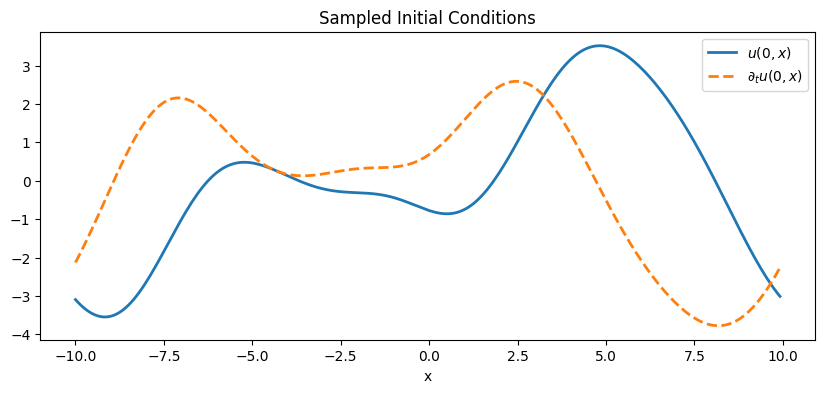

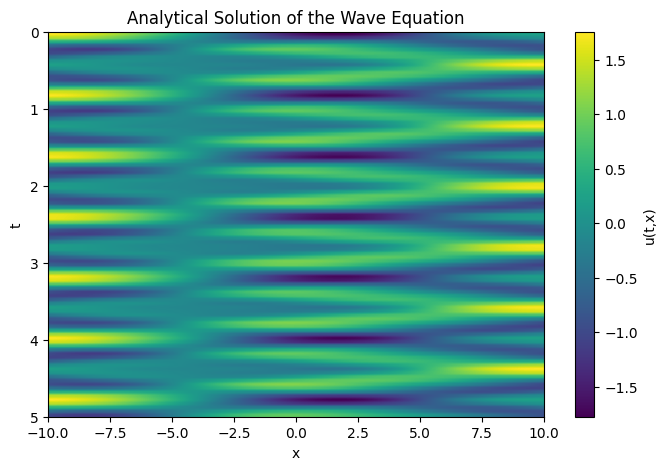

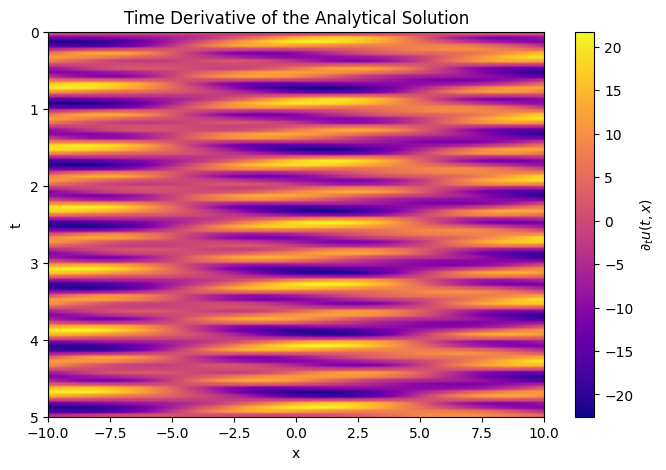

/var/folders/9z/g5qd8cf95dg743cjhmdb6zsw0000gn/T/ipykernel_14170/200737117.py:120: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_t = np.trapz((u_t_t_x**2 + c**2 * u_x_x**2), x)


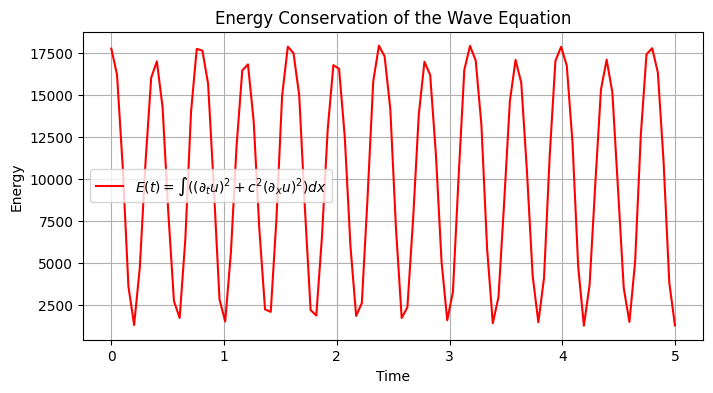

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def sample_initial_conditions(Nx, L, bumps_range = [0,0], add_poly = False):
    """Generate diverse initial conditions using random sinusoids and localized Gaussians."""
    x = np.linspace(-L, L, Nx, endpoint=False)
    
    # Random Fourier components for smooth periodic functions
    k_max = 10  # Maximum wave number
    amplitudes = np.random.randn(k_max) * np.exp(-np.linspace(0, k_max, k_max)**2 / 10)
    phases = np.random.uniform(0, 2 * np.pi, k_max)
    
    u0 = np.sum([a * np.sin(k * np.pi * x / L + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)
    
    # Add random Gaussian bumps for localized features
    if bumps_range[1] > bumps_range[0]:
        num_bumps = np.random.randint(bumps_range[0], bumps_range[1])
        for _ in range(num_bumps):
            center = np.random.uniform(-L, L)
            width = np.random.uniform(0.1 * L, 0.5 * L)
            height = np.random.uniform(-1, 1)
            u0 += height * np.exp(-((x - center) / width) ** 2)
    
    # Add polynomial perturbations
    if add_poly:
        poly_coeffs = np.random.randn(3) * 0.1  # Random cubic polynomial
        u0 += poly_coeffs[0] * x**3 + poly_coeffs[1] * x**2 + poly_coeffs[2] * x
        
    # Random initial velocity (derivative structure similar to u0)
    u_t0 = np.sum([a * np.cos(k * np.pi * x / L + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)
    
    return x, u0, u_t0

def fourier_coefficients(u0, ut0, x, L, c, N_modes=50):
    """Compute Fourier coefficients A_n and B_n from sampled initial conditions."""
    Nx = len(x)
    k_n = np.fft.fftfreq(Nx, d=(2*L/Nx)) * np.pi  # Wave numbers
    u0_hat = np.fft.fft(u0) / Nx
    ut0_hat = np.fft.fft(ut0) / Nx
    
    A_n = u0_hat[:N_modes]  # Fourier coefficients for u0
    B_n = np.zeros(N_modes, dtype=complex)
    nonzero_indices = np.abs(k_n[:N_modes]) > 0  # Avoid division by zero
    B_n[nonzero_indices] = ut0_hat[:N_modes][nonzero_indices] / (c * k_n[:N_modes][nonzero_indices])
    
    return A_n, B_n, k_n[:N_modes]

def analytical_wave_solution(x, t, A_n, B_n, k_n, c):
    """Compute the analytical solution u(t, x) and u_t(t, x) from Fourier coefficients."""
    u_t_x = np.zeros_like(x, dtype=complex)
    u_t_t_x = np.zeros_like(x, dtype=complex)
    for n in range(len(A_n)):
        omega_n = c * k_n[n]
        u_t_x += (A_n[n] * np.cos(omega_n * t) + B_n[n] * np.sin(omega_n * t)) * np.exp(1j * k_n[n] * x)
        u_t_t_x += (-omega_n * A_n[n] * np.sin(omega_n * t) + omega_n * B_n[n] * np.cos(omega_n * t)) * np.exp(1j * k_n[n] * x)
    
    return u_t_x.real, u_t_t_x.real  # Return real parts

def compute_spatial_derivative(u_x_t, x, L):
    """Compute the spatial derivative ∂_x u using the Fourier method."""
    Nx = len(x)
    k_n = np.fft.fftfreq(Nx, d=(2*L/Nx)) * np.pi  # Wave numbers
    u_x_t_hat = np.fft.fft(u_x_t)  # Fourier transform
    du_dx_t_hat = 1j * k_n * u_x_t_hat  # Spectral derivative
    du_dx_t = np.fft.ifft(du_dx_t_hat).real  # Inverse transform
    return du_dx_t

# Parameters
Nx = 256   # Number of spatial points
Nt = 100   # Number of time steps
L = 10.0   # Domain size [-L, L]
T = 5.0    # Final time
c = 50.0    # Wave speed

# Sample initial conditions
x, u0, ut0 = sample_initial_conditions(Nx, L)

# Compute Fourier coefficients
A_n, B_n, k_n = fourier_coefficients(u0, ut0, x, L, c)

# Compute wave evolution analytically
t_vals = np.linspace(0, T, Nt)
u_analytical = np.array([analytical_wave_solution(x, t, A_n, B_n, k_n, c)[0] for t in t_vals])
u_t_analytical = np.array([analytical_wave_solution(x, t, A_n, B_n, k_n, c)[1] for t in t_vals])

# Plot sampled initial conditions
plt.figure(figsize=(10, 4))
plt.plot(x, u0, label=r'$u(0, x)$', linewidth=2)
plt.plot(x, ut0, label=r'$\partial_t u(0, x)$', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.title('Sampled Initial Conditions')
plt.show()

# Plot the analytical solution
plt.figure(figsize=(8, 5))
plt.imshow(u_analytical, aspect='auto', extent=[-L, L, T, 0], cmap='viridis')
plt.colorbar(label='u(t,x)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Analytical Solution of the Wave Equation')
plt.show()

# Plot the time derivative of the solution
plt.figure(figsize=(8, 5))
plt.imshow(u_t_analytical, aspect='auto', extent=[-L, L, T, 0], cmap='plasma')
plt.colorbar(label=r'$\partial_t u(t,x)$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Analytical Solution')
plt.show()

# Compute energy over time
energy_values = []
for n in range(Nt):
    u_t_x, u_t_t_x = analytical_wave_solution(x, t_vals[n], A_n, B_n, k_n, c)
    u_x_x = compute_spatial_derivative(u_t_x, x, L)
    
    # Compute integral E(t) = ∫ ((∂_t u)^2 + c^2 (∂_x u)^2) dx
    energy_t = np.trapz((u_t_t_x**2 + c**2 * u_x_x**2), x)
    energy_values.append(energy_t)

# Plot the energy conservation over time
plt.figure(figsize=(8, 4))
plt.plot(t_vals, energy_values, label=r'$E(t) = \int ((\partial_t u)^2 + c^2 (\partial_x u)^2) dx$', color='red')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Conservation of the Wave Equation')
plt.legend()
plt.grid()
plt.show()

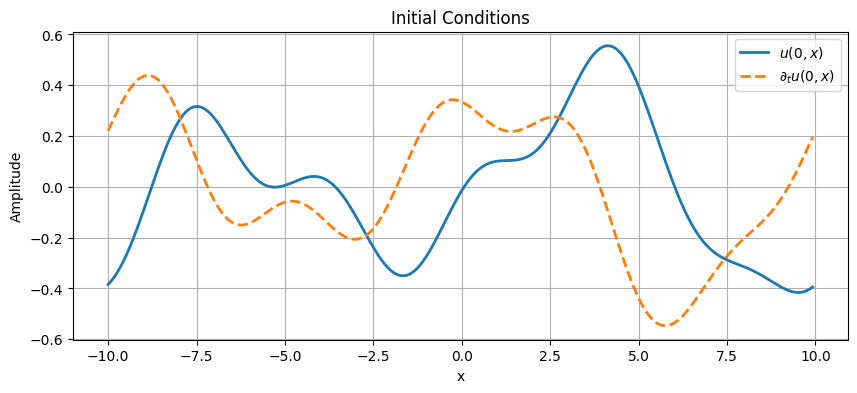

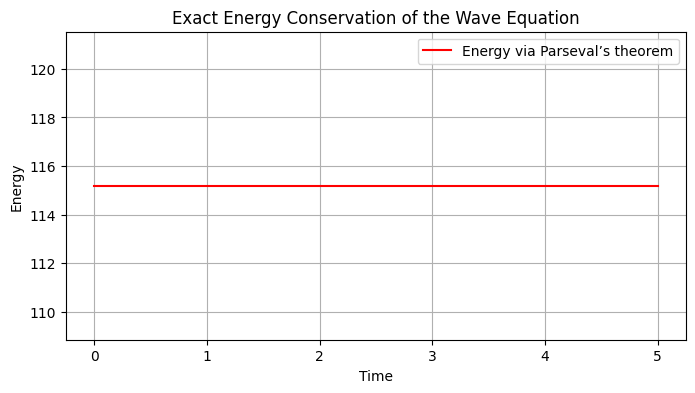

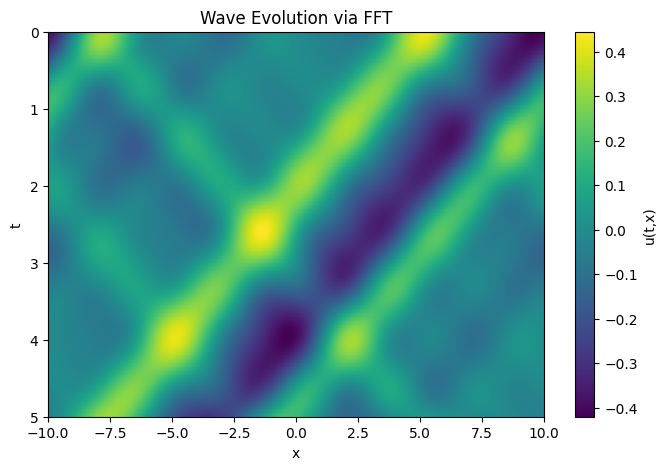

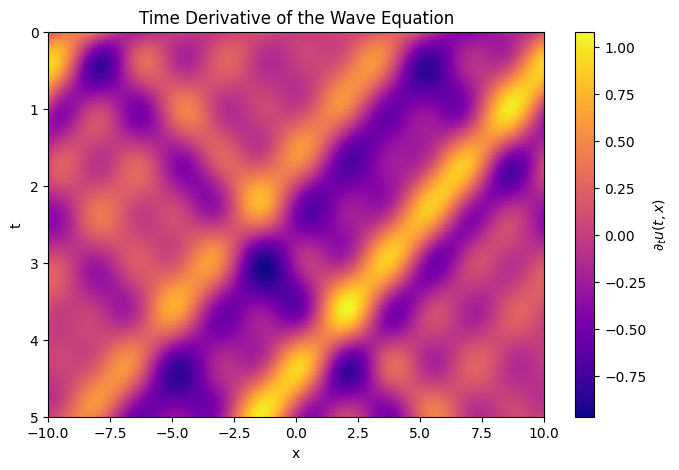

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_initial_conditions_sinusoidal(Nx, L):
    """Generate smooth initial conditions as a sum of sinusoids, then transform to Fourier space."""
    x = np.linspace(-L, L, Nx, endpoint=False)

    # Create initial condition as sum of sinusoids
    k_max = 10  
    amplitudes = np.random.randn(k_max) * np.exp(-np.linspace(0, k_max, k_max)**2 / 10)
    phases = np.random.uniform(0, 2 * np.pi, k_max)
    
    u0 = np.sum([a * np.sin(k * np.pi * x / L + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)
    ut0 = np.sum([a * np.cos(k * np.pi * x / L + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)

    # Convert to Fourier space
    u0_hat = np.fft.fft(u0)
    ut0_hat = np.fft.fft(ut0)

    # Ensure conjugate symmetry for real IFFT
    u0_hat[Nx//2:] = np.conj(np.flip(u0_hat[:Nx//2]))
    ut0_hat[Nx//2:] = np.conj(np.flip(ut0_hat[:Nx//2]))

    return u0, ut0, u0_hat, ut0_hat, x

def evolve_wave_fft(Nx, t_vals, x_vals, L, T, c):
    """Evolve the wave equation using FFT-based spectral solution."""
    dt = T / Nt
    Nx = len(x_vals)
    k = np.fft.fftfreq(Nx, d=(2*L/Nx)) * np.pi  # Wave numbers

    # Sample smooth initial conditions
    u0, ut0, u0_hat, ut0_hat, x = sample_initial_conditions_sinusoidal(Nx, L)

    # Compute Fourier coefficients for evolution
    A_n = u0_hat
    B_n = np.zeros_like(A_n)
    nonzero_indices = np.abs(k) > 1e-10  
    B_n[nonzero_indices] = ut0_hat[nonzero_indices] / (c * k[nonzero_indices])

    # Initialize storage
    energy_vals = []
    u_data = np.zeros((Nt, Nx))
    ut_data = np.zeros((Nt, Nx))

    for i, t in enumerate(t_vals):
        cos_term = np.cos(c * k * t)
        sin_term = np.sin(c * k * t)
        
        # Compute u(x,t) and u_t(x,t) in Fourier space
        u_hat_t = A_n * cos_term + B_n * sin_term
        ut_hat_t = -c * k * A_n * sin_term + c * k * B_n * cos_term

        # Transform back to physical space
        u_data[i, :] = np.fft.ifft(u_hat_t).real
        ut_data[i, :] = np.fft.ifft(ut_hat_t).real

        # Compute energy using Parseval’s theorem
        energy_t = np.sum(np.abs(ut_hat_t)**2 + c**2 * np.abs(k * u_hat_t)**2) / Nx
        energy_vals.append(energy_t)

    return x, t_vals, u_data, ut_data, energy_vals, u0, ut0

# Parameters
Nx = 256   # Number of spatial points
Nt = 100   # Number of time steps
L = 10.0   # Domain size [-L, L]
T = 5.0    # Final time
c = 5.0    # Wave speed

# Solve the wave equation
x, t_vals, u_data, ut_data, energy_values, u0, ut0 = evolve_wave_fft(Nx, Nt, L, T, c)

# Plot Initial Conditions
plt.figure(figsize=(10, 4))
plt.plot(x, u0, label=r'$u(0, x)$', linewidth=2)
plt.plot(x, ut0, label=r'$\partial_t u(0, x)$', linestyle='dashed', linewidth=2)
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.title('Initial Conditions')
plt.legend()
plt.grid()
plt.show()

# Plot energy conservation
plt.figure(figsize=(8, 4))
plt.plot(t_vals, energy_values, label=r'Energy via Parseval’s theorem', color='red')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Exact Energy Conservation of the Wave Equation')
plt.legend()
plt.grid()
plt.show()

# Plot wave evolution
plt.figure(figsize=(8, 5))
plt.imshow(u_data, aspect='auto', extent=[-L, L, T, 0], cmap='viridis')
plt.colorbar(label='u(t,x)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Wave Evolution via FFT')
plt.show()

# Plot heatmap of time derivative
plt.figure(figsize=(8, 5))
plt.imshow(ut_data, aspect='auto', extent=[-L, L, T, 0], cmap='plasma')
plt.colorbar(label=r'$\partial_t u(t,x)$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Wave Equation')
plt.show()
